<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/KDD_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
# Step 1: Data Collection
enrollment_train = pd.read_csv('enrollment_train.csv')
log_train = pd.read_csv('log_train.csv')
truth_train = pd.read_csv('truth_train.csv',header=None)
truth_train.columns=['enrollment_id', 'dropout']
object_data = pd.read_csv('object.csv')

In [21]:
truth_train

,enrollment_id,dropout
0,1,0
1,3,0
2,4,0
3,5,0
4,6,0
...,...,...
120537,200898,1
120538,200900,1
120539,200901,1
120540,200904,1


In [22]:
enrollment_train

,enrollment_id,username,course_id
0,1,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila
1,3,1qXC7Fjbwp66GPQc6pHLfEuO8WKozxG4,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx
2,4,FIHlppZyoq8muPbdVxS44gfvceX9zvU7,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila
3,5,p1Mp7WkVfzUijX0peVQKSHbgd5pXyl4c,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx
4,6,dpK33RH9yepUAnyoywRwBt1AJzxGlaja,AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd
...,...,...,...
120537,200898,mAAuxtPoEddxQ2jPmf6WwqHOgdvhqrk2,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J
120538,200900,y6i20DJpIul6LihHwgZcWxbdAap5GcBP,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J
120539,200901,PPEydg4GXh52QanXuUYKbv8ENUSViBbd,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J
120540,200904,7k4xZXZirLFjbh80SpWNqJdTubgGglfv,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J


In [23]:
# Step 2: Data Preprocessing
# Merge enrollment and truth data
data = pd.merge(enrollment_train, truth_train, on='enrollment_id')

In [24]:
data

,enrollment_id,username,course_id,dropout
0,1,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
1,3,1qXC7Fjbwp66GPQc6pHLfEuO8WKozxG4,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx,0
2,4,FIHlppZyoq8muPbdVxS44gfvceX9zvU7,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0
3,5,p1Mp7WkVfzUijX0peVQKSHbgd5pXyl4c,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx,0
4,6,dpK33RH9yepUAnyoywRwBt1AJzxGlaja,AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd,0
...,...,...,...,...
120537,200898,mAAuxtPoEddxQ2jPmf6WwqHOgdvhqrk2,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1
120538,200900,y6i20DJpIul6LihHwgZcWxbdAap5GcBP,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1
120539,200901,PPEydg4GXh52QanXuUYKbv8ENUSViBbd,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1
120540,200904,7k4xZXZirLFjbh80SpWNqJdTubgGglfv,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1


In [25]:
# Aggregate activity log data
log_train['time'] = pd.to_datetime(log_train['time'])
log_aggregated = log_train.groupby('enrollment_id').agg({
    'time': ['min', 'max', 'count'],
    'event': lambda x: x.nunique(),
    'object': lambda x: x.nunique()
}).reset_index()
log_aggregated.columns = ['enrollment_id', 'start_time', 'end_time', 'activity_count', 'unique_events', 'unique_objects']

In [26]:
# Merge aggregated log data with main data
data = pd.merge(data, log_aggregated, on='enrollment_id')

In [27]:
data

,enrollment_id,username,course_id,dropout,start_time,end_time,activity_count,unique_events,unique_objects
0,1,9Uee7oEuuMmgPx2IzPfFkWgkHZyPbWr0,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0,2014-06-14 09:38:29,2014-07-11 09:52:58,314,5,95
1,3,1qXC7Fjbwp66GPQc6pHLfEuO8WKozxG4,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx,0,2014-06-19 08:43:27,2014-07-17 08:13:42,288,6,99
2,4,FIHlppZyoq8muPbdVxS44gfvceX9zvU7,DPnLzkJJqOOPRJfBxIHbQEERiYHu5ila,0,2014-06-15 01:44:10,2014-07-02 11:32:47,99,5,29
3,5,p1Mp7WkVfzUijX0peVQKSHbgd5pXyl4c,7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx,0,2014-06-19 05:41:37,2014-07-18 23:08:33,633,6,111
4,6,dpK33RH9yepUAnyoywRwBt1AJzxGlaja,AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd,0,2014-07-01 14:59:37,2014-07-02 01:23:26,23,5,16
...,...,...,...,...,...,...,...,...,...
120537,200898,mAAuxtPoEddxQ2jPmf6WwqHOgdvhqrk2,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1,2014-07-24 13:30:06,2014-07-24 13:30:06,1,1,1
120538,200900,y6i20DJpIul6LihHwgZcWxbdAap5GcBP,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1,2014-07-24 13:54:05,2014-07-24 13:54:05,1,1,1
120539,200901,PPEydg4GXh52QanXuUYKbv8ENUSViBbd,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1,2014-07-24 14:07:42,2014-07-24 14:11:41,8,4,6
120540,200904,7k4xZXZirLFjbh80SpWNqJdTubgGglfv,9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,1,2014-07-24 15:07:50,2014-07-24 15:07:50,1,1,1


In [28]:
# Feature engineering
data['duration'] = (data['end_time'] - data['start_time']).dt.total_seconds()
data = data.drop(['username', 'course_id', 'start_time', 'end_time'], axis=1)

In [29]:
data

,enrollment_id,dropout,activity_count,unique_events,unique_objects,duration
0,1,0,314,5,95,2333669.0
1,3,0,288,6,99,2417415.0
2,4,0,99,5,29,1504117.0
3,5,0,633,6,111,2568416.0
4,6,0,23,5,16,37429.0
...,...,...,...,...,...,...
120537,200898,1,1,1,1,0.0
120538,200900,1,1,1,1,0.0
120539,200901,1,8,4,6,239.0
120540,200904,1,1,1,1,0.0


<Axes: >

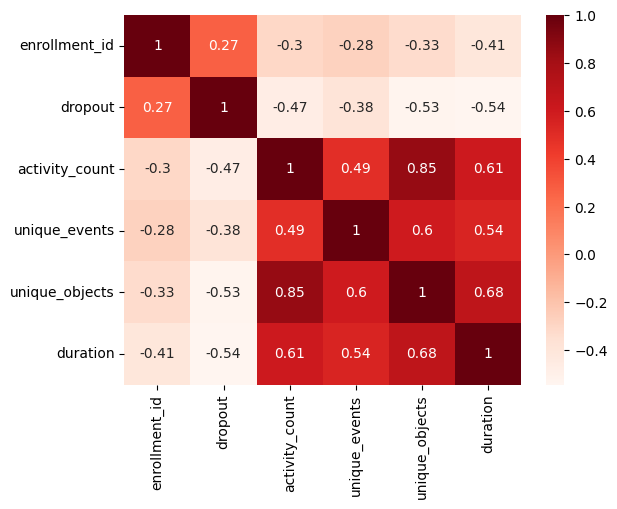

In [45]:
import seaborn as sns
sns.heatmap(data.corr(),cmap='Reds',annot=True)

In [30]:
# Normalization
scaler = StandardScaler()
data[['activity_count', 'unique_events', 'unique_objects', 'duration']] = scaler.fit_transform(
    data[['activity_count', 'unique_events', 'unique_objects', 'duration']]
)

In [46]:
data.columns

Index(['enrollment_id', 'dropout', 'activity_count', 'unique_events',
       'unique_objects', 'duration'],
      dtype='object')

In [43]:
data.corr()

,enrollment_id,dropout,activity_count,unique_events,unique_objects,duration
enrollment_id,1.000000,0.269829,-0.304201,-0.276785,-0.330250,-0.408322
dropout,0.269829,1.000000,-0.466880,-0.383983,-0.529119,-0.543977
activity_count,-0.304201,-0.466880,1.000000,0.490701,0.853951,0.607599
unique_events,-0.276785,-0.383983,0.490701,1.000000,0.598891,0.544930
unique_objects,-0.330250,-0.529119,0.853951,0.598891,1.000000,0.675095
duration,-0.408322,-0.543977,0.607599,0.544930,0.675095,1.000000


<Axes: >

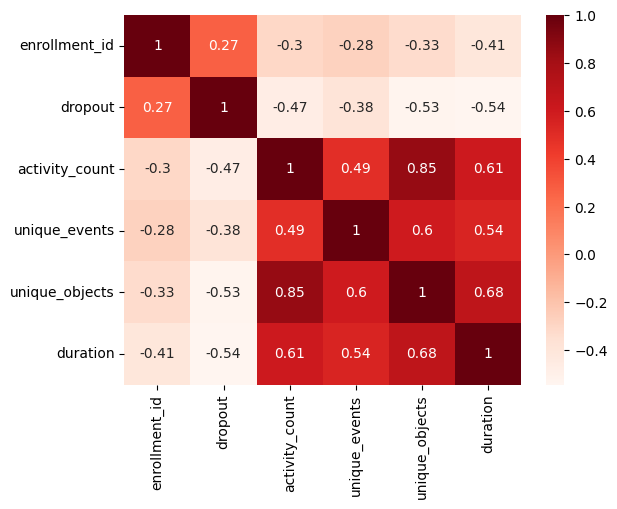

In [44]:
import seaborn as sns
sns.heatmap(data.corr(),cmap='Reds',annot=True)

In [32]:
# Step 3: Data Merging
X = data.drop(['enrollment_id', 'dropout'], axis=1).values
y = data['dropout'].values

In [47]:
print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (120542, 4)
y.shape : (120542,)


In [35]:
# Step 4: Model Training
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train

array([[-0.30869023,  0.47297219, -0.31340469,  0.54955606],
       [ 1.22515992,  1.44535951,  2.58177826,  2.47238138],
       [-0.43592204, -0.01322147, -0.49435362, -0.64568275],
       ...,
       [-0.47126421, -1.47180245, -0.67530256, -0.64599835],
       [-0.47126421, -1.47180245, -0.67530256, -0.64599835],
       [ 0.5112481 ,  0.95916585,  1.72227082,  2.12919582]])

In [37]:
y_train

array([1, 0, 1, ..., 1, 1, 0])

In [38]:
# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [39]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
1206/1206 - 11s - loss: 0.3646 - accuracy: 0.8594 - val_loss: 0.3538 - val_accuracy: 0.8590 - 11s/epoch - 9ms/step
Epoch 2/20
1206/1206 - 5s - loss: 0.3483 - accuracy: 0.8620 - val_loss: 0.3536 - val_accuracy: 0.8594 - 5s/epoch - 4ms/step
Epoch 3/20
1206/1206 - 4s - loss: 0.3479 - accuracy: 0.8627 - val_loss: 0.3535 - val_accuracy: 0.8591 - 4s/epoch - 4ms/step
Epoch 4/20
1206/1206 - 5s - loss: 0.3475 - accuracy: 0.8625 - val_loss: 0.3534 - val_accuracy: 0.8582 - 5s/epoch - 5ms/step
Epoch 5/20
1206/1206 - 7s - loss: 0.3472 - accuracy: 0.8624 - val_loss: 0.3531 - val_accuracy: 0.8595 - 7s/epoch - 6ms/step
Epoch 6/20
1206/1206 - 5s - loss: 0.3471 - accuracy: 0.8623 - val_loss: 0.3531 - val_accuracy: 0.8588 - 5s/epoch - 4ms/step
Epoch 7/20
1206/1206 - 5s - loss: 0.3474 - accuracy: 0.8626 - val_loss: 0.3532 - val_accuracy: 0.8581 - 5s/epoch - 4ms/step
Epoch 8/20
1206/1206 - 7s - loss: 0.3472 - accuracy: 0.8629 - val_loss: 0.3531 - val_accuracy: 0.8578 - 7s/epoch - 6ms/step
Epoch 

In [50]:
# Step 5: Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy=accuracy_score(y_test,y_pred)
conf=confusion_matrix(y_test,y_pred)
report=classification_report(y_test,y_pred)
print(f" Confusion Matrix : \n{conf}")
print(f" Classification Report : \n{report}")
print(f" Validation Accuracy : \n{accuracy*100} %")


754/754 [==============================] - 2s 3ms/step
 Confusion Matrix : 
[[ 2551  2510]
 [  823 18225]]
 Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.50      0.60      5061
           1       0.88      0.96      0.92     19048

    accuracy                           0.86     24109
   macro avg       0.82      0.73      0.76     24109
weighted avg       0.85      0.86      0.85     24109

 Validation Accuracy : 
86.17528723713136 %
